In [1]:
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import anndata

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import pandas as pd


In [2]:
# Read the data
rxrx_adata = anndata.read_h5ad("../data/rxrx3_embeddings.h5ad")
cp_adata = anndata.read_h5ad("../data/rxrx3_cellprofiler.h5ad")

print(f'Starting rxrx_adata: {rxrx_adata.shape}')
print(f'Starting cp_adata: {cp_adata.shape}')

# Reformat treatment_column slightly
rxrx_adata.obs['treatment'] = rxrx_adata.obs['treatment'].str.replace('EGFR_guide_\d+', 'EGFR_KO', regex=True)
cp_adata.obs['treatment'] = cp_adata.obs['treatment'].str.replace('EGFR_guide_\d+', 'EGFR_KO', regex=True)

rxrx_adata.obs['log10_concentration'] = rxrx_adata.obs['concentration'].apply(lambda x: np.log10(x))
cp_adata.obs['log10_concentration'] = cp_adata.obs['concentration'].apply(lambda x: np.log10(x))

# Clean up the CellProfiler data
from utils import clean_adata
cp_adata = clean_adata(cp_adata, standardize=False)
print(f'After cleaning cp_adata: {cp_adata.shape}')

# Filter out features that I don't think are useful when aggregated
from utils import filter_var_names_by_pattern
remove_terms = ['ImageNumber', 'BoxMaximum', 'BoxMinimum', 'Location_Center']
cp_adata = filter_var_names_by_pattern(cp_adata, remove_terms)
print(f'After removing {len(remove_terms)} features from cp_adata: {cp_adata.shape}')

# Filter for just EGFR-KO related samples
from utils import get_crispr_perturbations
crispr_rxrx_adata = get_crispr_perturbations(rxrx_adata)
crispr_cp_adata = get_crispr_perturbations(cp_adata)

print(f'crispr_rxrx_adata: {crispr_rxrx_adata.shape}')
print(f'crispr_cp_adata: {crispr_cp_adata.shape}')



Starting rxrx_adata: (1149, 128)
Starting cp_adata: (1149, 6536)
After cleaning cp_adata: (1147, 6524)
Number of features removed: 702
After removing 4 features from cp_adata: (1147, 5822)
crispr_rxrx_adata: (257, 128)
crispr_cp_adata: (256, 5822)


,cells_AreaShape_Area,cells_AreaShape_BoundingBoxArea,cells_AreaShape_Center_X,cells_AreaShape_Center_Y,cells_AreaShape_Compactness,cells_AreaShape_ConvexArea,cells_AreaShape_Eccentricity,cells_AreaShape_EquivalentDiameter,cells_AreaShape_EulerNumber,cells_AreaShape_Extent,...,nucleoli_child_Location_MaxIntensity_Z_Actin_mad,nucleoli_child_Location_MaxIntensity_Z_ConA_mad,nucleoli_child_Location_MaxIntensity_Z_DNA_mad,nucleoli_child_Location_MaxIntensity_Z_Mito_mad,nucleoli_child_Location_MaxIntensity_Z_RNA_mad,nucleoli_child_Location_MaxIntensity_Z_WGA_mad,nucleoli_child_Number_Object_Number_mad,nucleoli_child_Parent_Nucleoli_mad,nucleoli_child_nucleoli_child_count,treatment
0,1573.851172,2813.270133,1104.271096,1014.592833,2.054926,1904.973496,0.714688,43.501245,0.993884,0.588405,...,0.0,0.0,0.0,0.0,0.0,0.0,1292.0,1292.0,5168.0,Neratinib


<class 'str'>
############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.9 as the correlation limit. Change this limit to fit your needs...
    Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
    Single_Label Multi_Classification problem 
    Loaded train data. Shape = (1147, 5823)
    Single_Label Multi_Classification problem 
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
####################################

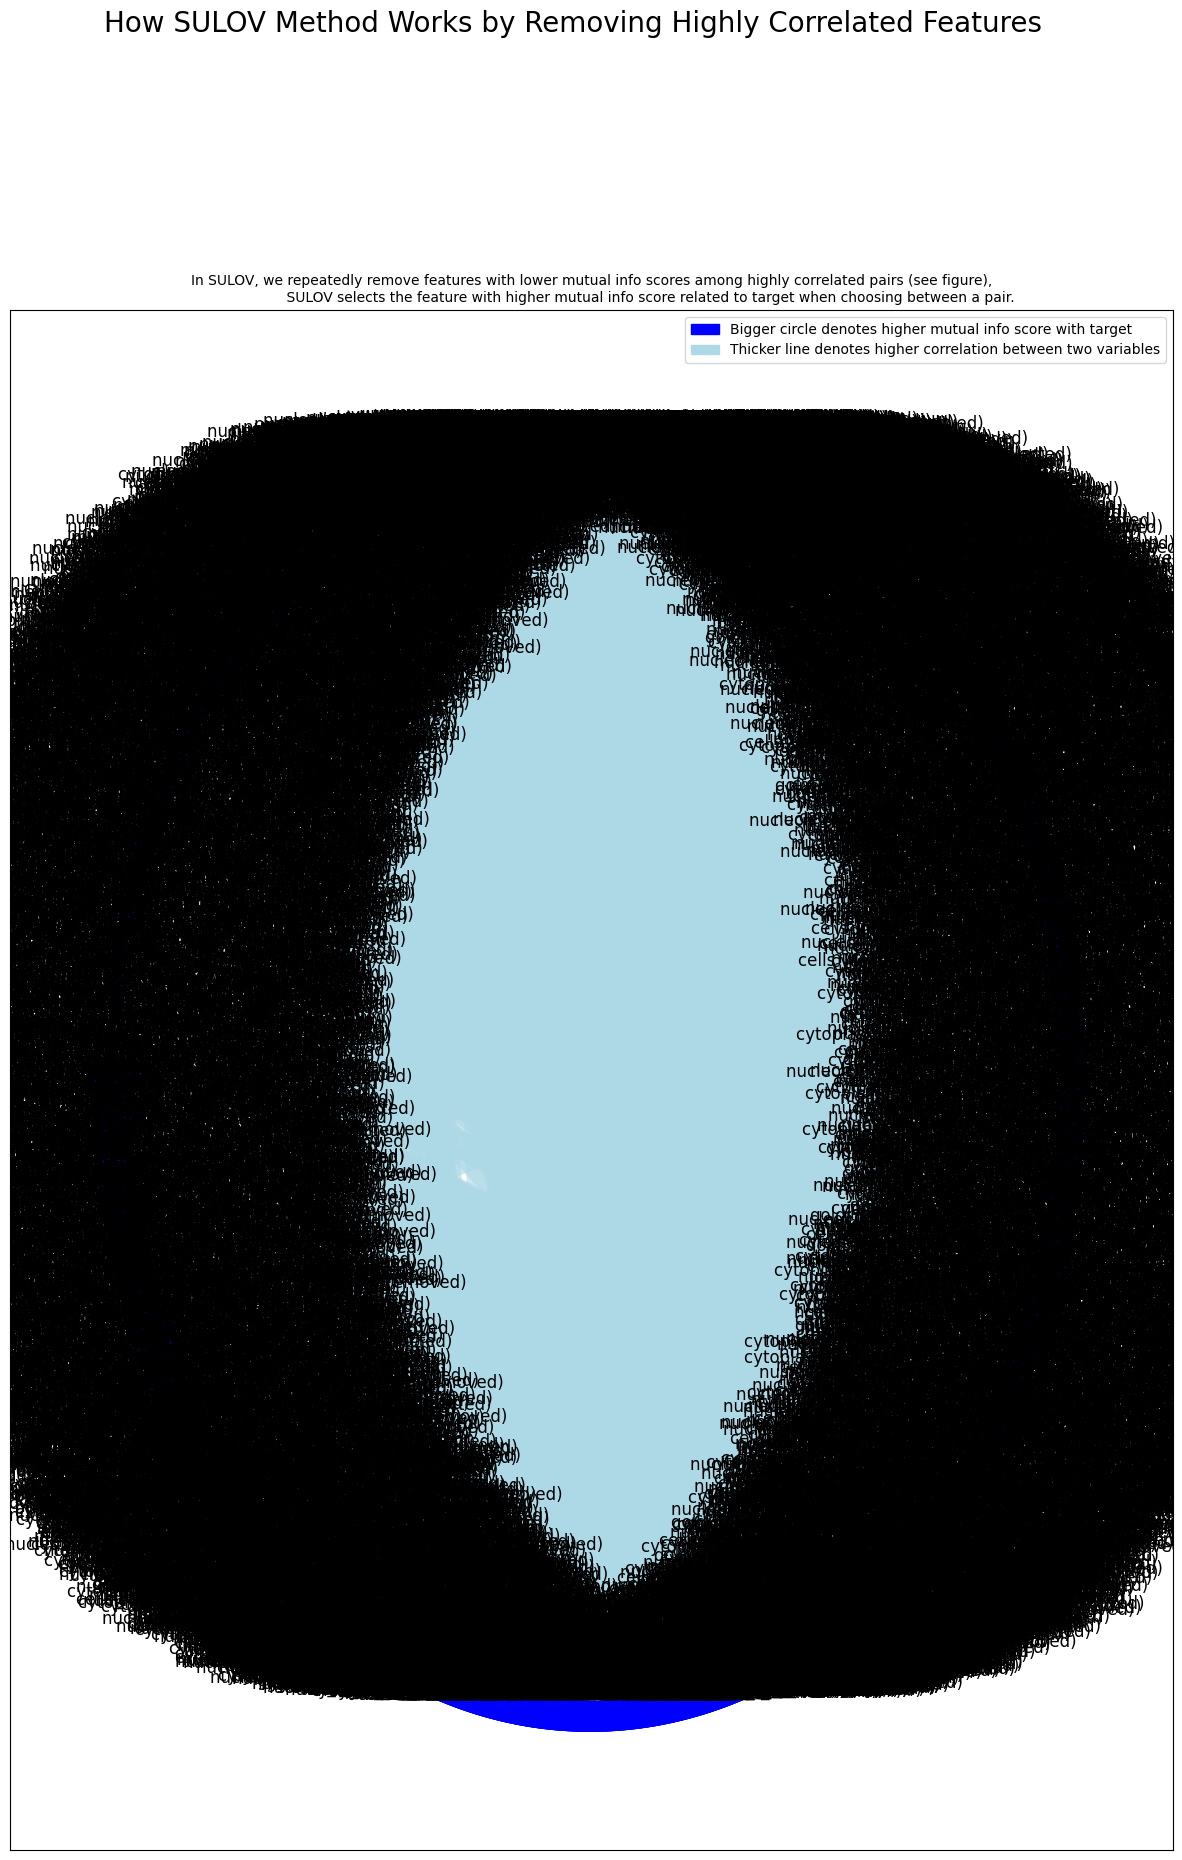

Time taken for SULOV method = 146 seconds
    Adding 0 categorical variables to reduced numeric variables  of 1954
Finally 1954 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 390 features per iteration...
    Number of booster rounds = 100
    Completed XGBoost feature selection in 72 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 1073 important features. Too many to print...
Total Time taken for featurewiz selecti

In [17]:
import pandas as pd
from featurewiz import featurewiz

def run_featurewiz_on_adata(adata, target_col, corr_limit=0.9, verbose=1):
    """
    Run featurewiz on an AnnData object for feature selection.

    Parameters:
        adata (AnnData): Input AnnData object.
        target_col (str): Column in adata.obs to use as the target variable.
        corr_limit (float): Correlation limit for featurewiz. Defaults to 0.9.
        verbose (int): Verbosity level for featurewiz. Defaults to 1.

    Returns:
        list: Selected features.
    """
    # Ensure target column exists
    if target_col not in adata.obs.columns:
        raise ValueError(f"Target column '{target_col}' not found in adata.obs.")

    # Convert data to DataFrame
    X = adata.X
    y = adata.obs[target_col].values
    feature_names = adata.var_names
    df = pd.DataFrame(X, columns=feature_names)
    df[target_col] = y

    # Run featurewiz
    display(df.head(1))
    print(type(target_col))
    selected_features, _ = featurewiz(
        dataname=df,
        target=target_col,
        corr_limit=corr_limit,
        verbose=verbose,
    )

    return selected_features

# Example usage
selected_features = run_featurewiz_on_adata(cp_adata, target_col="treatment")
print(f"Selected features: {selected_features}")


In [16]:
featurewiz(data=cp_adata.to_df(), target='target', dataname=None)

featurewiz has selected 0.8 as the correlation limit. Change this limit to fit your needs...
You supplied data =                      cells_AreaShape_Area  cells_AreaShape_BoundingBoxArea  \
well_id                                                                      
compound-004_31_C45           1573.851172                      2813.270133   
compound-003_20_K40           1509.921378                      2647.945230   
compound-003_1_J23            1367.285824                      2333.285824   
gene-081_2_U15                1445.322301                      2495.774626   
compound-004_9_D44            1536.266707                      2936.387718   
...                                   ...                              ...   
gene-157_8_AC24               1459.153771                      2499.335945   
gene-157_7_T29                1435.222002                      2455.671952   
gene-157_9_H03                1520.368631                      2613.290709   
gene-157_3_P06               

TypeError: 'NoneType' object is not subscriptable